<a href="https://colab.research.google.com/github/Alban998/buildWithAI/blob/main/Th%C3%A8me_1_IRN_RHIMA_distanciel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas rasterio scikit-learn shapely rasterstats matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 97.7 MB/s eta 0:00:00


Définir un raster de référence dont la résolution, la projection et l’emprise
serviront de base pour aligner toutes les autres couches raster.

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

# =========================
# 1) Paramétrage d'entrée
# =========================
raster_paths = [
    "Elevation.tif", "Distance_aux_routes.tif", "Curvature.tif", "TWI.tif", "TPI.tif", "pente.tif",
    "Distance_oued_Bouregreg.tif", "Distance_aux_zones_urbaines.tif",
    "Occupation_du_sol.tif", "Distance_aux_terrains_agricoles.tif", "ndvi.tif"
]

# Déclaration explicite des rasters catégoriels (à adapter au besoin)
categorical_names = {
    "occupation_du_sol.tif",  # noms en minuscules
    # Si tu as d'autres rasters caté., ajoute-les ici
}

# =========================
# 2) Raster de référence
# =========================
# Recommandé : un raster continu bien géoréférencé, résolution 30 m
ref_raster = rasterio.open(raster_paths[0])  # ici le 1er de la liste
ref_meta = ref_raster.meta.copy()

# =========================
# 3) Dossier de sortie
# =========================
output_dir = "rasters_aligned"
os.makedirs(output_dir, exist_ok=True)

# =========================
# 4) Fonction de traitement
# =========================
def resample_and_save(src_path, ref_raster, output_path):
    with rasterio.open(src_path) as src:
        data = src.read(1)
        src_dtype = data.dtype
        name_lower = os.path.basename(src_path).lower()

        # Détection catégoriel / continu
        is_categorical = (name_lower in categorical_names) or np.issubdtype(src_dtype, np.integer)

        if is_categorical:
            # Catégoriel : nearest, dtype entier, nodata compatible
            # On conserve le dtype si c'est un entier, sinon on force en uint8
            out_dtype = src_dtype if np.issubdtype(src_dtype, np.integer) else np.uint8
            nodata_val = np.iinfo(out_dtype).max  # ex. 255 pour uint8, 32767 pour int16, etc.
            resamp = Resampling.nearest
        else:
            # Continu : bilinear, float32, nodata = -9999.0
            out_dtype = np.float32
            nodata_val = -9999.0
            resamp = Resampling.bilinear

        # Préparer tableau destination
        dest = np.full((ref_raster.height, ref_raster.width), nodata_val, dtype=out_dtype)

        # Reprojection / Rééchantillonnage (on passe src_nodata/dst_nodata)
        reproject(
            source=data,
            destination=dest,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_raster.transform,
            dst_crs=ref_raster.crs,
            resampling=resamp,
            src_nodata=src.nodata,
            dst_nodata=nodata_val,
        )

        # Nettoyage des NaN uniquement pour les flottants (rasters continus)
        if (not is_categorical) and np.issubdtype(dest.dtype, np.floating):
            dest[np.isnan(dest)] = nodata_val

        # Métadonnées de sortie basées sur le raster de référence
        new_meta = ref_raster.meta.copy()
        new_meta.update({
            "dtype": out_dtype,
            "count": 1,
            "nodata": nodata_val
        })

        # Écrire le fichier aligné
        with rasterio.open(output_path, "w", **new_meta) as dst:
            dst.write(dest, 1)

        # Petit log utile
        print(f"[OK] {os.path.basename(src_path)} -> {os.path.basename(output_path)} | "
              f"{'CAT' if is_categorical else 'CONT'} | resamp={resamp.name} | dtype={out_dtype} | nodata={nodata_val}")

# =========================
# 5) Traitement en boucle
# =========================
for path in raster_paths:
    out_path = os.path.join(output_dir, os.path.basename(path))
    resample_and_save(path, ref_raster, out_path)

print("\n✅ Tous les rasters ont été alignés et exportés dans:", output_dir)


[OK] Elevation.tif -> Elevation.tif | CAT | resamp=nearest | dtype=int32 | nodata=2147483647
[OK] Distance_aux_routes.tif -> Distance_aux_routes.tif | CONT | resamp=bilinear | dtype=<class 'numpy.float32'> | nodata=-9999.0
[OK] Curvature.tif -> Curvature.tif | CONT | resamp=bilinear | dtype=<class 'numpy.float32'> | nodata=-9999.0
[OK] TWI.tif -> TWI.tif | CONT | resamp=bilinear | dtype=<class 'numpy.float32'> | nodata=-9999.0
[OK] TPI.tif -> TPI.tif | CONT | resamp=bilinear | dtype=<class 'numpy.float32'> | nodata=-9999.0
[OK] pente.tif -> pente.tif | CONT | resamp=bilinear | dtype=<class 'numpy.float32'> | nodata=-9999.0
[OK] Distance_oued_Bouregreg.tif -> Distance_oued_Bouregreg.tif | CONT | resamp=bilinear | dtype=<class 'numpy.float32'> | nodata=-9999.0
[OK] Distance_aux_zones_urbaines.tif -> Distance_aux_zones_urbaines.tif | CONT | resamp=bilinear | dtype=<class 'numpy.float32'> | nodata=-9999.0
[OK] Occupation_du_sol.tif -> Occupation_du_sol.tif | CAT | resamp=nearest | dtype=ui

In [ ]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
from rasterstats import zonal_stats

# -----------------------------
# Entrées
# -----------------------------
aligned_dir = "rasters_aligned"
aligned_rasters = sorted([f for f in os.listdir(aligned_dir) if f.endswith(".tif")])

# Nom(s) de rasters catégoriels (en minuscules). Adapte si besoin.
CATEGORICAL_NAMES = {
    "occupation_du_sol.tif",  # <- mets ici le nom exact en minuscules
}

# -----------------------------
# Chargement des points
# -----------------------------
ravine_pts = gpd.read_file("point_ravine1.shp")
non_ravine_pts = gpd.read_file("non_ravine.shp")

# Harmoniser le CRS
if ravine_pts.crs != non_ravine_pts.crs:
    non_ravine_pts = non_ravine_pts.to_crs(ravine_pts.crs)

# -----------------------------
# Utilitaires
# -----------------------------
def sample_categorical_at_points(raster_path, gdf):
    """Retourne la valeur du pixel sous chaque point (catégoriel)."""
    with rasterio.open(raster_path) as src:
        # Récupérer nodata pour éventuellement le convertir en NaN
        nodata = src.nodata
        coords = [(geom.x, geom.y) for geom in gdf.geometry]
        samples = list(src.sample(coords))  # liste de tableaux shape (1,)
        vals = np.array([s[0] for s in samples])
        # Convertir nodata -> NaN pour éviter 255 dans le dataset
        if nodata is not None:
            vals = np.where(vals == nodata, np.nan, vals)
        return vals

def buffer_mean_continuous(raster_path, gdf, radius_m=60):
    """Retourne la moyenne dans un buffer (continu)."""
    stats = zonal_stats(
        vectors=gdf.buffer(radius_m),
        raster=raster_path,
        stats=["mean"],
        nodata=None,       # on laisse rasterstats gérer; sinon passer la valeur
        geojson_out=True
    )
    return np.array([f["properties"]["mean"] for f in stats])

def is_categorical(raster_filename, raster_path):
    """Heuristique: nom connu OU dtype entier."""
    name_lower = raster_filename.lower()
    if name_lower in CATEGORICAL_NAMES:
        return True
    # Sinon, on inspecte le dtype du raster
    with rasterio.open(raster_path) as src:
        return np.issubdtype(src.dtypes[0], np.integer)

# -----------------------------
# Extraction principale
# -----------------------------
def extract_features_for(points_gdf, label_value, radius_m=60):
    col_values = {}
    for rname in aligned_rasters:
        rpath = os.path.join(aligned_dir, rname)
        var_name = os.path.splitext(rname)[0]  # nom de colonne sans .tif

        if is_categorical(rname, rpath):
            # Catégoriel: valeur du pixel sous le point
            vals = sample_categorical_at_points(rpath, points_gdf)
        else:
            # Continu: moyenne sur buffer
            vals = buffer_mean_continuous(rpath, points_gdf, radius_m=radius_m)

        col_values[var_name] = vals

    # Construire DataFrame
    df = pd.DataFrame(col_values)
    # Ajouter ID et label si dispo
    if "ID" in points_gdf.columns:
        df["ID"] = points_gdf["ID"].values
    else:
        df["ID"] = np.arange(len(points_gdf))  # fallback
    df["label"] = label_value
    return df

# -----------------------------
# Appliquer aux deux classes
# -----------------------------
df_ravine = extract_features_for(ravine_pts, label_value=1, radius_m=60)
df_non_ravine = extract_features_for(non_ravine_pts, label_value=0, radius_m=60)

# Fusion et export
df_all = pd.concat([df_ravine, df_non_ravine], ignore_index=True)

# Option: si tu veux éliminer les lignes avec NaN (ex. points tombant sur nodata catégoriel)
# df_all = df_all.dropna(axis=0, how="any")

df_all.to_csv("dataset_ravine_final.csv", index=False)
print("✅ Extraction terminée → dataset_ravine_final.csv")


✅ Extraction terminée → dataset_ravine_final.csv


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Confusion Matrix:
[[75 11]
 [ 2 84]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92        86
           1       0.88      0.98      0.93        86

    accuracy                           0.92       172
   macro avg       0.93      0.92      0.92       172
weighted avg       0.93      0.92      0.92       172

Accuracy:  0.92
Precision: 0.88
Recall:    0.98
F1 Score:  0.93
AUC Score: 0.96


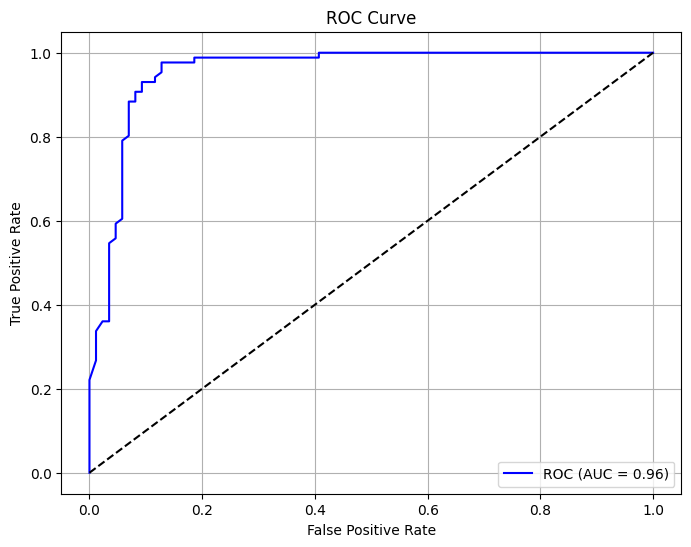

/tmp/ipython-input-3312560158.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


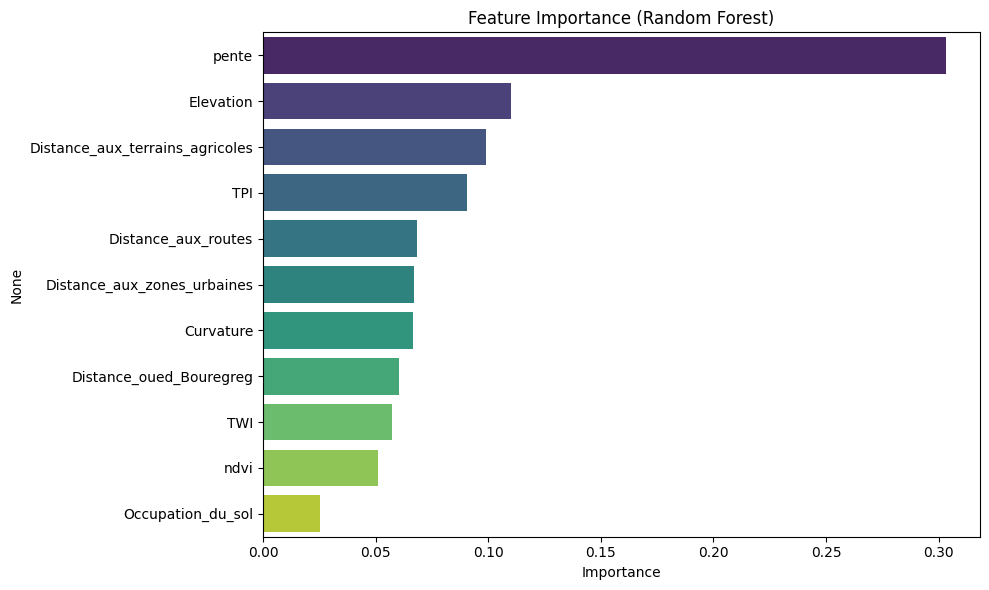

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

# === Chargement des données
df = pd.read_csv("dataset_ravine_final.csv")
X = df.drop(columns=["label", "ID"])  # Supprime l'ID pour éviter de biaiser
y = df["label"]

# === Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# === Optimisation des hyperparamètres
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# === Prédictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# === Évaluation
print("Best hyperparameters:", grid_search.best_params_)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall:    {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.2f}")
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

# === Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})", color="blue")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.legend()
plt.show()

# === Feature Importance
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import rasterio
from osgeo import gdal
import geopandas as gpd
from rasterio.features import geometry_mask

# ======================
# Paramètres d'entrée
# ======================
aligned_folder = "rasters_aligned"
ref_name = "Elevation.tif"                # raster de référence fiable
aoi_shp   = "study_area.shp"         # <-- ton shapefile AOI
output_tif = "susceptibility_proba_aoi.tif"
NODATA_OUT = -9999.0                 # nodata de sortie
# best_model doit déjà être en mémoire / importé

# ======================
# Ouvrir rasters alignés
# ======================
aligned_rasters = sorted([f for f in os.listdir(aligned_folder) if f.endswith(".tif")])
rasters = [rasterio.open(os.path.join(aligned_folder, r)) for r in aligned_rasters]

# ======================
# Référence géo
# ======================
ref_path = os.path.join(aligned_folder, ref_name)
with rasterio.open(ref_path) as ref_raster:
    ref_meta = ref_raster.meta.copy()
    ref_crs = ref_raster.crs
    ref_transform = ref_raster.transform
    H, W = ref_raster.height, ref_raster.width
    wkt = ref_raster.crs.to_wkt()

# ======================
# Charger AOI et la projeter
# ======================
aoi = gpd.read_file(aoi_shp)
if aoi.crs is None:
    raise ValueError("Le shapefile AOI n'a pas de CRS. Définis/assigne un CRS.")
if aoi.crs != ref_crs:
    aoi = aoi.to_crs(ref_crs)

# ======================
# Construire un masque AOI (True = hors AOI)
# ======================
# geometry_mask retourne True là où c'est en dehors des géométries
aoi_mask = geometry_mask(
    geometries=list(aoi.geometry),
    out_shape=(H, W),
    transform=ref_transform,
    invert=True   # True -> True = à l'intérieur ; on inversera après
)
# Ici aoi_mask == True à l'intérieur de l'AOI
outside_aoi = ~aoi_mask  # True = hors AOI

# ======================
# Lire toutes les bandes + masque NoData global
# ======================
bands = [r.read(1) for r in rasters]

mask_list = []
for arr, r in zip(bands, rasters):
    m = np.zeros(arr.shape, dtype=bool)
    if r.nodata is not None:
        m |= (arr == r.nodata)
    if np.issubdtype(arr.dtype, np.floating):
        m |= ~np.isfinite(arr)
    mask_list.append(m)

nodata_any = np.logical_or.reduce(mask_list)

# Masque final à NE PAS prédire : hors AOI OU NoData dans au moins une couche
invalid_mask = outside_aoi | nodata_any

# ======================
# Empiler et prédire uniquement à l'intérieur de l'AOI et sur pixels valides
# ======================
stack = np.stack(bands, axis=-1)  # (H, W, C)
H, W, C = stack.shape
stack_2d = stack.reshape(-1, C)

valid_idx = ~invalid_mask.flatten()  # True = on peut prédire
pred_flat = np.full(stack_2d.shape[0], np.nan, dtype=np.float32)

# >>> Prédiction uniquement sur pixels valides
pred_flat[valid_idx] = best_model.predict_proba(stack_2d[valid_idx])[:, 1]

proba_map = pred_flat.reshape(H, W)

# Appliquer NoData hors AOI + zones invalides
proba_map[invalid_mask] = NODATA_OUT

# ======================
# Export GeoTIFF
# ======================
ref_meta.update({
    "dtype": "float32",
    "count": 1,
    "crs": ref_crs,
    "transform": ref_transform,
    "nodata": NODATA_OUT,
    # Optionnel: compression et tuilage pour fichiers plus légers/rapides
    "compress": "LZW",
    "tiled": True,
    "blockxsize": 256,
    "blockysize": 256
})
with rasterio.open(output_tif, "w", **ref_meta) as dst:
    dst.write(proba_map.astype("float32"), 1)

print("✅ Raster exporté :", output_tif)

# ======================
# Corriger/forcer la projection WKT (ArcGIS)
# ======================
prj_path = "Nord_Maroc.prj"
if not os.path.exists(prj_path):
    with open(prj_path, "w") as f:
        f.write(wkt)
with open(prj_path) as f:
    wkt_txt = f.read()

ds = gdal.Open(output_tif, gdal.GA_Update)
ds.SetProjection(wkt_txt)
ds = None
print("✅ Projection WKT écrite :", output_tif)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


✅ Raster exporté : susceptibility_proba_aoi.tif
✅ Projection WKT écrite : susceptibility_proba_aoi.tif


/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


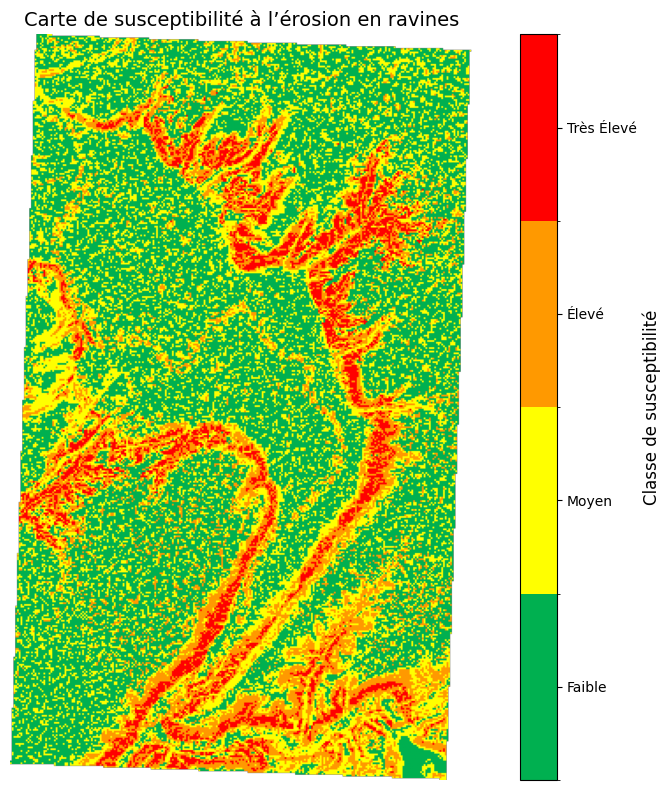

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import rasterio

# Charger le raster de probabilité
with rasterio.open("susceptibility_proba_aoi.tif") as src:
    proba_map = src.read(1)
    nodata = src.nodata  # devrait être -9999.0 selon ton export

# Masque des pixels invalides (NoData ou non-finies)
invalid = np.zeros_like(proba_map, dtype=bool)
if nodata is not None:
    invalid |= (proba_map == nodata)
invalid |= ~np.isfinite(proba_map)

# Clipper les valeurs valides à [0,1]
proba_map = proba_map.copy()
valid = ~invalid
proba_map[valid] = np.clip(proba_map[valid], 0.0, 1.0)

# Reclassification en 4 classes sur les SEULS pixels valides
classes = np.zeros(proba_map.shape, dtype=np.uint8)  # 0 = fond masqué
classes[(valid) & (proba_map <= 0.25)] = 1   # Faible
classes[(valid) & (proba_map > 0.25) & (proba_map <= 0.5)]  = 2   # Moyen
classes[(valid) & (proba_map > 0.5)  & (proba_map <= 0.75)] = 3   # Élevé
classes[(valid) & (proba_map > 0.75)] = 4   # Très élevé

# Masquer le fond (classes==0) pour le rendre transparent
classes_masked = np.ma.masked_where(classes == 0, classes)

# Nouvelle colormap : vert → jaune → orange → rouge
cmap = mcolors.ListedColormap(["#00b050", "#ffff00", "#ff9900", "#ff0000"])
cmap.set_bad(alpha=0.0)  # zones masquées = transparentes

# Bornes des classes
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Affichage
plt.figure(figsize=(10, 8))
im = plt.imshow(classes_masked, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=[1, 2, 3, 4])
cbar.ax.set_yticklabels(["Faible", "Moyen", "Élevé", "Très Élevé"])
cbar.set_label("Classe de susceptibilité", fontsize=12)
plt.title("Carte de susceptibilité à l’érosion en ravines", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.savefig("carte_susceptibilite.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
